In [1]:
%run ../scripts/notebook_settings.py
import glob

In [2]:
#Test of sgkit
import sgkit as sg
import xarray as xr

Test case

In [3]:
# Simulate 20 variants across 50 samples, and add them all to the same cohort.
ds = sg.simulate_genotype_call_dataset(n_variant=20, n_sample=50)
ds["sample_cohort"] = xr.DataArray(np.full(ds.dims['samples'], 0), dims="samples")
ds

/tmp/59736424/ipykernel_1659959/881559314.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds["sample_cohort"] = xr.DataArray(np.full(ds.dims['samples'], 0), dims="samples")


<xarray.Dataset> Size: 5kB
Dimensions:             (contigs: 1, variants: 20, alleles: 2, samples: 50,
                         ploidy: 2)
Dimensions without coordinates: contigs, variants, alleles, samples, ploidy
Data variables:
    contig_id           (contigs) <U1 4B '0'
    variant_contig      (variants) int64 160B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    variant_position    (variants) int64 160B 0 1 2 3 4 5 ... 14 15 16 17 18 19
    variant_allele      (variants, alleles) |S1 40B b'T' b'T' b'A' ... b'A' b'T'
    sample_id           (samples) <U3 600B 'S0' 'S1' 'S2' ... 'S47' 'S48' 'S49'
    call_genotype       (variants, samples, ploidy) int8 2kB 0 0 1 0 ... 0 1 1 1
    call_genotype_mask  (variants, samples, ploidy) bool 2kB False ... False
    sample_cohort       (samples) int64 400B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    contigs:  ['0']
    source:   sgkit-0.10.0

In [4]:
# Determine the number of alt alleles (call dosage), and then calculate diversity in windows of size 5
ds["call_dosage"] = ds["call_genotype"].sum(dim="ploidy")
dsw = sg.window_by_variant(ds, size=5)
sg.diversity(dsw, merge=False).stat_diversity.values

array([[2.49232323],
       [2.50464646],
       [2.44343434],
       [2.4810101 ]])

In [5]:
ds

<xarray.Dataset> Size: 13kB
Dimensions:             (contigs: 1, variants: 20, alleles: 2, samples: 50,
                         ploidy: 2)
Dimensions without coordinates: contigs, variants, alleles, samples, ploidy
Data variables:
    contig_id           (contigs) <U1 4B '0'
    variant_contig      (variants) int64 160B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    variant_position    (variants) int64 160B 0 1 2 3 4 5 ... 14 15 16 17 18 19
    variant_allele      (variants, alleles) |S1 40B b'T' b'T' b'A' ... b'A' b'T'
    sample_id           (samples) <U3 600B 'S0' 'S1' 'S2' ... 'S47' 'S48' 'S49'
    call_genotype       (variants, samples, ploidy) int8 2kB 0 0 1 0 ... 0 1 1 1
    call_genotype_mask  (variants, samples, ploidy) bool 2kB False ... False
    sample_cohort       (samples) int64 400B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    call_dosage         (variants, samples) int64 8kB 0 1 1 1 1 1 ... 0 2 1 1 2
Attributes:
    contigs:  ['0']
    source:   sgkit-0.10.0

In [6]:
# Tajimas D test
sg.Tajimas_D(ds)["stat_Tajimas_D"].values

array([[1.80837205],
       [1.80837205],
       [1.84075183],
       [1.75440574],
       [1.85034584],
       [1.77479301],
       [1.84075183],
       [1.82156381],
       [1.84674809],
       [1.85154509],
       [1.84075183],
       [1.70643568],
       [1.79278178],
       [1.58171355],
       [1.85034584],
       [1.77479301],
       [1.75440574],
       [1.77479301],
       [1.84075183],
       [1.85034584]])

The zarr formats are different between scikit-allel and sgkit. Sgkit is in general more powerful, but has less implemented functions and is harder to use. It is however under current development, and seems to have a good deal of flexibility.
Going to learn it because it seems fun, time to dive into another Jerome Kelleher ecosystem. In addition, it has very good support for windowing and subsetting due to its use of Xarray.

In [7]:
ds = sg.load_dataset("../data/Gorilla_gorilla_gorilla")

In [8]:
sg.variant_stats(ds)

<xarray.Dataset> Size: 8GB
Dimensions:                   (variants: 21463034, alleles: 2, samples: 46,
                               ploidy: 2, contigs: 26, filters: 2,
                               region_index_values: 21487,
                               region_index_fields: 6)
Dimensions without coordinates: variants, alleles, samples, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/25)
    variant_n_called          (variants) int64 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_call_rate         (variants) float64 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_n_het             (variants) int64 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_n_hom_ref         (variants) int64 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_n_hom_alt         (variants) int64 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_n_non_ref         (variants) int64 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    ...                        ...
    variant_filter            (variants, filters) bool 43MB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    variant_id                (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask           (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length            (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position          (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality           (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [9]:
np.unique(ds.variant_contig.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int8)

In [10]:
#Guess is that last chrom is chrX
pd.Series(ds.variant_contig.values).value_counts()

0     1627541
2     1588843
1     1498730
4     1332382
5     1199257
3     1178356
6     1153274
7     1048980
8     1020183
10     987279
9      973588
11     865730
12     854911
13     791558
18     763742
14     695159
23     666044
16     612986
15     564824
17     555624
20     466439
19     417460
21     328392
22     271752
Name: count, dtype: int64

Trying different approaches, exploring sgkit.

In [11]:
dir(sg)

['DIM_ALLELE',
 'DIM_PLOIDY',
 'DIM_SAMPLE',
 'DIM_VARIANT',
 'Fst',
 'Garud_H',
 'Tajimas_D',
 'Weir_Goudet_beta',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_version',
 'accelerate',
 'call_allele_frequencies',
 'cohort_allele_frequencies',
 'cohorts',
 'convert_call_to_index',
 'convert_probability_to_call',
 'count_call_alleles',
 'count_cohort_alleles',
 'count_variant_alleles',
 'count_variant_genotypes',
 'create_genotype_call_dataset',
 'create_genotype_dosage_dataset',
 'display',
 'display_genotypes',
 'display_pedigree',
 'distance',
 'distarray',
 'divergence',
 'diversity',
 'filter_partial_calls',
 'genee',
 'genomic_relationship',
 'gwas_linear_regression',
 'hardy_weinberg_test',
 'hybrid_inverse_relationship',
 'hybrid_relationship',
 'identity_by_state',
 'individual_heterozygosity',
 'infer_call_ploidy',
 'infer_sample_ploidy',
 'infer_variant_ploidy',
 '

Figuring out the slicing and indexing available.

In [12]:
dsw = sg.window_by_variant(ds, size=10000000)
#sample_cohort = np.repeat([0, 1], ds.sizes["samples"] // 2)
#ds["sample_cohort"] = xr.DataArray(sample_cohort, dims="samples")
dsw

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 24, variants: 21463034, samples: 46,
                           ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6,
                           alleles: 2)
Dimensions without coordinates: windows, variants, samples, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields, alleles
Data variables: (12/19)
    window_contig         (windows) int64 192B 0 1 2 3 4 5 ... 18 19 20 21 22 23
    window_start          (windows) int64 192B 0 1627541 ... 20525238 20796990
    window_stop           (windows) int64 192B 1627541 3126271 ... 21463034
    call_genotype         (variants, samples, ploidy) int8 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 987MB dask.array<chunksize=(1000, 46), meta=np.ndarray>
    ...                    ...
    variant_filter        (variants, filters) bool 43MB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [13]:
contig20 = dsw.isel(windows=20)
contig20["call_dosage"] = contig20["call_genotype"].sum(dim="ploidy")
contig20.call_genotype_mask

<xarray.DataArray 'call_genotype_mask' (variants: 21463034, samples: 46,
                                        ploidy: 2)> Size: 2GB
dask.array<open_dataset-call_genotype_mask, shape=(21463034, 46, 2), dtype=bool, chunksize=(1000, 46, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    description:

In [14]:
dp = sg.count_variant_alleles(ds)
#dp.attrs["long_name"] = "Allele_count"
#xr.plot.hist(dp, range=(0, 100), bins=30, size=8, edgecolor="black");

In [15]:
dp.variant_allele_count[10000:10020].values.sum(axis=1)

array([86, 54, 52, 52, 62, 52, 72, 82, 84, 84, 80, 80, 84, 74, 74, 72, 58,
       76, 64, 54], dtype=uint64)

In [16]:
sg.count_variant_alleles(ds).variant_allele_count[:2].values

array([[79,  1],
       [34, 30]], dtype=uint64)

In [17]:
# Tallies the number of missing values for every individual.
ds.call_genotype_mask[:,:,1].sum(axis=0).values

array([  521162,  1062945,  1891047,   218394,  1249664,   982557,
         815552,  4748823,   178275,   551603,   747520,  1057752,
         891003,   717251,   635315,   729161,   176410,   860213,
         876177,  3280223,  3022250,  3848640,  3090813,  6017525,
        2465026,  3715156,  1149340,   958005,  2719604,  2590706,
        3023392,   815016,  5648161,  3750648,  4441541,  4232015,
        5291813,  3769067,  5255927, 10615834, 10948581,  9897386,
        5563261,  5064485,  4297111,  6515774])

In [18]:
# A little fun discovery: A few cases of 0/-1, so you have to use to make sure there is no missing.
# Relevant for the variant-level filter
ds.call_genotype_mask[:,:,1].sum(axis=0).values

array([  521162,  1062945,  1891047,   218394,  1249664,   982557,
         815552,  4748823,   178275,   551603,   747520,  1057752,
         891003,   717251,   635315,   729161,   176410,   860213,
         876177,  3280223,  3022250,  3848640,  3090813,  6017525,
        2465026,  3715156,  1149340,   958005,  2719604,  2590706,
        3023392,   815016,  5648161,  3750648,  4441541,  4232015,
        5291813,  3769067,  5255927, 10615834, 10948581,  9897386,
        5563261,  5064485,  4297111,  6515774])

In [19]:
# Tallies the number of values for every individual, its the same per ind, but is a fine sanity check.
ds.call_genotype_mask[:,:,0].count(axis=0).values

array([21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034, 21463034, 21463034,
       21463034, 21463034, 21463034, 21463034])

In [20]:
# Together, they calculate the missing rate across all called SNPs. Many inds are horrible (missing rate above 10%)
missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=0).values/ds.call_genotype_mask[:,:,0].count(axis=0).values
missing_rate

array([0.02428184, 0.04952445, 0.08810716, 0.01017536, 0.0296555 ,
       0.04577904, 0.03799798, 0.2212559 , 0.00830614, 0.02570014,
       0.03482825, 0.02027905, 0.01212354, 0.03341797, 0.02960043,
       0.03397288, 0.00821925, 0.01065972, 0.01137621, 0.15283128,
       0.14081187, 0.15341871, 0.14400634, 0.28036693, 0.0865633 ,
       0.17309557, 0.05354975, 0.04463512, 0.12671107, 0.12070549,
       0.14086508, 0.03797301, 0.24062609, 0.14940157, 0.2069391 ,
       0.19717692, 0.24655475, 0.17560737, 0.24488276, 0.49461013,
       0.51011339, 0.46113639, 0.25920198, 0.23596314, 0.20020986,
       0.30358122])

<Axes: ylabel='Count'>

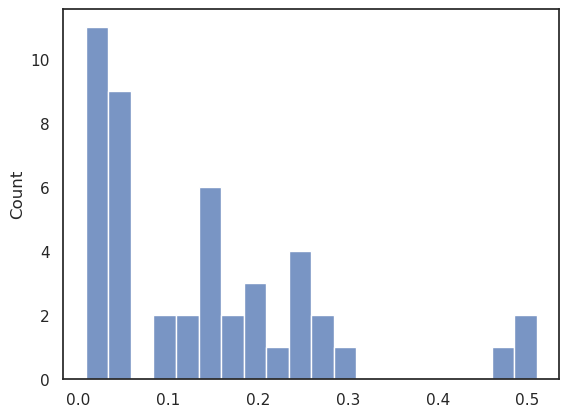

In [21]:
#Would prefer working without having too much data loss for PCA, so will restrict analysis to inds with less than 10% missing.
sns.histplot(missing_rate, bins=20)

A way to group samples is through cohorts, which also could be through missing rate instead of metadata.

In [22]:
(missing_rate//0.1).astype(np.int64)

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 4, 5, 4, 2, 2,
       2, 3])

In [23]:
# Adding as a data variable
ds["sample_cohort"] = xr.DataArray((missing_rate//0.1).astype(np.int64), dims="samples")

In [24]:
# Subsetting only for the good samples.
ds22 = ds.sel(samples=ds.sample_cohort.isin([0]))

In [25]:
ds22

<xarray.Dataset> Size: 3GB
Dimensions:               (variants: 21463034, samples: 22, ploidy: 2,
                           contigs: 26, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 944MB dask.array<chunksize=(1000, 22, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 944MB dask.array<chunksize=(1000, 22, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 472MB dask.array<chunksize=(1000, 22), meta=np.ndarray>
    contig_id             (contigs) object 208B dask.array<chunksize=(26,), meta=np.ndarray>
    contig_length         (contigs) float64 208B dask.array<chunksize=(26,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 176B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [26]:
# Now identifying all calls with no missing data in the 22 good samples.
# Make sure that it is second genotype because of the 0/-1
missing_rate = ds22.call_genotype_mask[:,:,1].sum(axis=1).values/ds22.call_genotype_mask[:,:,1].count(axis=1).values
missing_rate

array([0.13636364, 0.27272727, 0.13636364, ..., 0.63636364, 0.45454545,
       0.68181818])

In [27]:
np.median(missing_rate), np.mean(missing_rate), np.sum(missing_rate == 0)/len(missing_rate)
# 56 % of sites in the 22 are called across all.

(0.0, 0.04140181418221424, 0.5612950154204667)

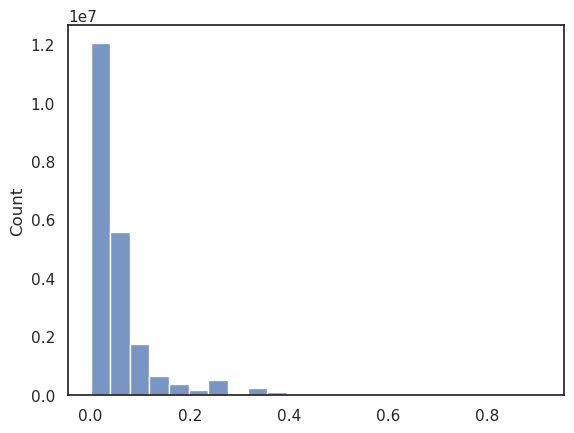

In [28]:
g = sns.histplot(missing_rate, bins=23)
#g.set(xlim=(0, 0.25))

Now we know which variants to remove.

In [29]:
ds22ss = ds22.isel(variants=(missing_rate == 0))

Lastly, Maf filter and LD prune before the PCA. Remember to also remove high-frequency variants, as a fixed variant will cause the PCA SVD step to not converge.

<Axes: ylabel='Count'>

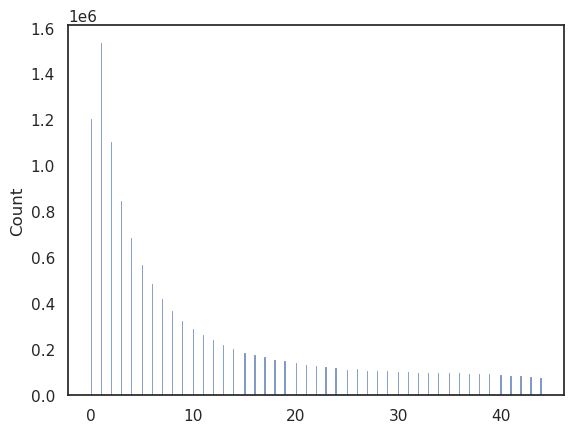

In [30]:
# Example of Call dosage distribution
ds22ss["call_dosage"] = ds22ss["call_genotype"].sum(dim="ploidy")
sns.histplot(ds22ss.call_dosage.sum(axis=1).values)

In [31]:
ds22ss["call_dosage"] = ds22ss["call_genotype"].sum(dim="ploidy")
ds22ss = ds22ss.isel(variants=((ds22ss.call_dosage.sum(axis=1).values >= 6)
                               & (ds22ss.call_dosage.sum(axis=1).values <= 20)))

In [32]:
ds22ss

<xarray.Dataset> Size: 1GB
Dimensions:               (variants: 3737214, samples: 22, ploidy: 2,
                           contigs: 26, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/18)
    call_genotype         (variants, samples, ploidy) int8 164MB dask.array<chunksize=(999, 22, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 164MB dask.array<chunksize=(999, 22, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 82MB dask.array<chunksize=(999, 22), meta=np.ndarray>
    contig_id             (contigs) object 208B dask.array<chunksize=(26,), meta=np.ndarray>
    contig_length         (contigs) float64 208B dask.array<chunksize=(26,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id_mask       (variants) bool 4MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 7MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 15MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 15MB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 176B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    call_dosage           (variants, samples) int64 658MB dask.array<chunksize=(999, 22), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [33]:
pruned20 = sg.ld_prune(sg.window_by_variant(ds22ss, size=100), threshold=0.9)

In [34]:
pruned20

<xarray.Dataset> Size: 354MB
Dimensions:               (windows: 37384, variants: 1087631, samples: 22,
                           ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6,
                           alleles: 2)
Dimensions without coordinates: windows, variants, samples, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields, alleles
Data variables: (12/21)
    window_contig         (windows) int64 299kB 0 0 0 0 0 0 ... 23 23 23 23 23
    window_start          (windows) int64 299kB 0 100 200 ... 3737109 3737209
    window_stop           (windows) int64 299kB 100 200 300 ... 3737209 3737214
    call_genotype         (variants, samples, ploidy) int8 48MB dask.array<chunksize=(998, 22, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 48MB dask.array<chunksize=(998, 22, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 24MB dask.array<chunksize=(998, 22), meta=np.ndarray>
    ...                    ...
    variant_id_mask       (variants) bool 1MB dask.array<chunksize=(998,), meta=np.ndarray>
    variant_length        (variants) int16 2MB dask.array<chunksize=(998,), meta=np.ndarray>
    variant_position      (variants) int32 4MB dask.array<chunksize=(998,), meta=np.ndarray>
    variant_quality       (variants) float32 4MB dask.array<chunksize=(998,), meta=np.ndarray>
    sample_cohort         (samples) int64 176B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    call_dosage           (variants, samples) int64 191MB dask.array<chunksize=(998, 22), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [35]:
pca_results = sg.pca(pruned20).compute()

In [36]:
pca_results

<xarray.Dataset> Size: 489MB
Dimensions:                              (samples: 22, components: 10,
                                          variants: 1087631, windows: 37384,
                                          ploidy: 2, contigs: 26, filters: 2,
                                          region_index_values: 21487,
                                          region_index_fields: 6, alleles: 2)
Dimensions without coordinates: samples, components, variants, windows, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields, alleles
Data variables: (12/27)
    sample_pca_projection                (samples, components) float32 880B 8...
    sample_pca_component                 (variants, components) float32 44MB ...
    sample_pca_explained_variance        (components) float32 40B 1.869e+05 ....
    sample_pca_explained_variance_ratio  (components) float32 40B 0.088 ... 0...
    sample_pca_loading                   (variants, components) float32 44MB ...
    call_alternate_allele_count          (variants, samples) int16 48MB 0 ... 0
    ...                                   ...
    variant_id_mask                      (variants) bool 1MB True True ... True
    variant_length                       (variants) int16 2MB 1 1 1 1 ... 1 1 1
    variant_position                     (variants) int32 4MB 5403141 ... 120...
    variant_quality                      (variants) float32 4MB 1.434e+03 ......
    sample_cohort                        (samples) int64 176B 0 0 0 0 ... 0 0 0
    call_dosage                          (variants, samples) int64 191MB 0 ... 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

[Text(0.5, 0, 'PC1, Variance explained 0.088'),
 Text(0, 0.5, 'PC2, Variance explained 0.0699')]

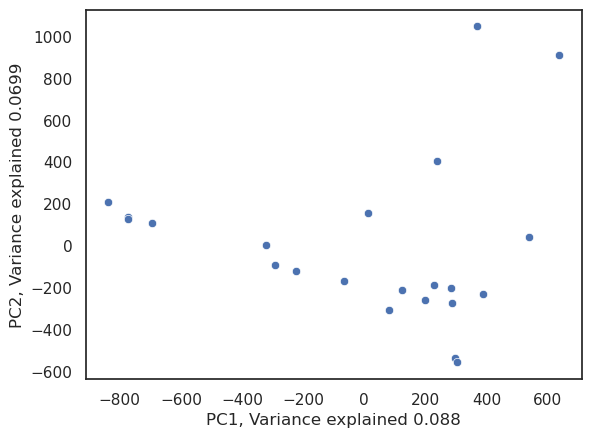

In [37]:
pcx = 0
pcy = 1
g =sns.scatterplot(x=pca_results.sample_pca_projection[:,pcx], y=pca_results.sample_pca_projection[:,pcy])
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcy].values))

<Axes: >

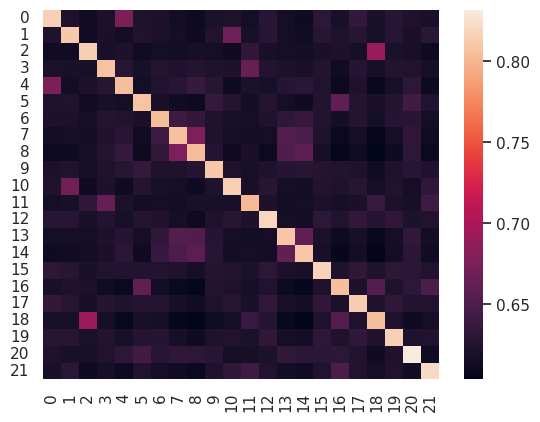

In [38]:
sns.heatmap(sg.identity_by_state(pruned20)["stat_identity_by_state"].values)

<Axes: >

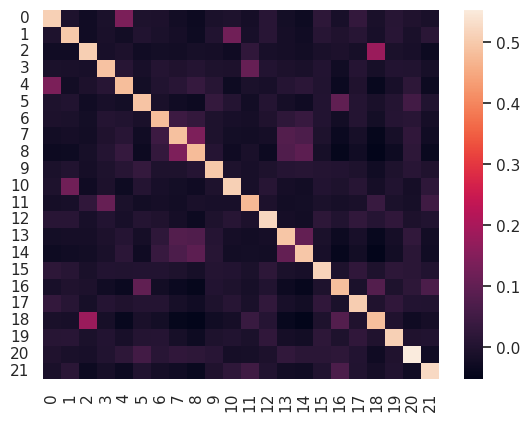

In [39]:
sns.heatmap(sg.Weir_Goudet_beta(pruned20)["stat_Weir_Goudet_beta"].values)

In [40]:
pruned20

<xarray.Dataset> Size: 354MB
Dimensions:               (windows: 37384, variants: 1087631, samples: 22,
                           ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6,
                           alleles: 2)
Dimensions without coordinates: windows, variants, samples, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields, alleles
Data variables: (12/21)
    window_contig         (windows) int64 299kB 0 0 0 0 0 0 ... 23 23 23 23 23
    window_start          (windows) int64 299kB 0 100 200 ... 3737109 3737209
    window_stop           (windows) int64 299kB 100 200 300 ... 3737209 3737214
    call_genotype         (variants, samples, ploidy) int8 48MB dask.array<chunksize=(998, 22, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 48MB dask.array<chunksize=(998, 22, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 24MB dask.array<chunksize=(998, 22), meta=np.ndarray>
    ...                    ...
    variant_id_mask       (variants) bool 1MB dask.array<chunksize=(998,), meta=np.ndarray>
    variant_length        (variants) int16 2MB dask.array<chunksize=(998,), meta=np.ndarray>
    variant_position      (variants) int32 4MB dask.array<chunksize=(998,), meta=np.ndarray>
    variant_quality       (variants) float32 4MB dask.array<chunksize=(998,), meta=np.ndarray>
    sample_cohort         (samples) int64 176B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    call_dosage           (variants, samples) int64 191MB dask.array<chunksize=(998, 22), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Implementing Fst heatmap. It gives an indexing error which I expect is because of the various windowing/filtering steps I've done, so I try a clean implemtation as it gave an error possibly due to my definitions of sample_cohort.

In [42]:
ds = sg.load_dataset("../data/Gorilla_gorilla_gorilla")
sample_cohort = range(len(ds["sample_id"]))
ds["sample_cohort"] = xr.DataArray(sample_cohort, dims="samples")
ds

<xarray.Dataset> Size: 6GB
Dimensions:               (variants: 21463034, samples: 46, ploidy: 2,
                           contigs: 26, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 987MB dask.array<chunksize=(1000, 46), meta=np.ndarray>
    contig_id             (contigs) object 208B dask.array<chunksize=(26,), meta=np.ndarray>
    contig_length         (contigs) float64 208B dask.array<chunksize=(26,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [43]:
#missing_rate_inds = ds.call_genotype_mask[:,:,1].sum(axis=0).values/ds.call_genotype_mask[:,:,1].count(axis=0).values
#ds = ds.isel(samples=(missing_rate_inds <= 0.2))
#ds

<Axes: ylabel='Count'>

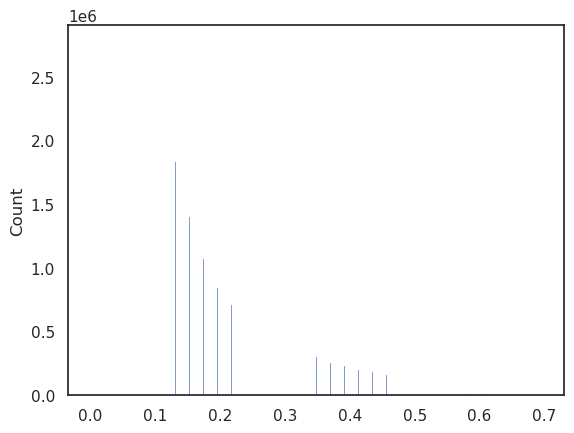

In [44]:
missing_rate = ds.call_genotype_mask[:,:,1].sum(axis=1).values/ds.call_genotype_mask[:,:,1].count(axis=1).values
sns.histplot(missing_rate)

In [45]:
# Also subsample to only use every 10th variant to avoid crashing.
ds = ds.isel(variants=(missing_rate == 0))
ds = ds.isel(variants=(np.array(range(len(ds.variants)))%10 == 0))
ds 

<xarray.Dataset> Size: 10MB
Dimensions:               (variants: 35679, samples: 46, ploidy: 2,
                           contigs: 26, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 2MB dask.array<chunksize=(999, 46), meta=np.ndarray>
    contig_id             (contigs) object 208B dask.array<chunksize=(26,), meta=np.ndarray>
    contig_length         (contigs) float64 208B dask.array<chunksize=(26,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 285kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 36kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 71kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [46]:
ds = sg.window_by_genome(ds)

In [47]:
ds = sg.Fst(ds)
fst_results = ds["stat_Fst"].values
fst_results

array([[[        nan,  0.02023358,  0.03470627, ..., -0.00071663,
          0.03058914,  0.11790009],
        [ 0.02023358,         nan,  0.02876117, ..., -0.02573606,
          0.02638294,  0.12313343],
        [ 0.03470627,  0.02876117,         nan, ..., -0.00020586,
          0.04468847,  0.09708445],
        ...,
        [-0.00071663, -0.02573606, -0.00020586, ...,         nan,
          0.02170205,  0.0944206 ],
        [ 0.03058914,  0.02638294,  0.04468847, ...,  0.02170205,
                 nan,  0.09852124],
        [ 0.11790009,  0.12313343,  0.09708445, ...,  0.0944206 ,
          0.09852124,         nan]]])

In [48]:
ds

<xarray.Dataset> Size: 40MB
Dimensions:               (windows: 1, cohorts_0: 46, cohorts_1: 46,
                           variants: 35679, cohorts: 46, alleles: 2,
                           samples: 46, ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6)
Dimensions without coordinates: windows, cohorts_0, cohorts_1, variants,
                                cohorts, alleles, samples, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/23)
    stat_Fst              (windows, cohorts_0, cohorts_1) float64 17kB dask.array<chunksize=(1, 46, 46), meta=np.ndarray>
    stat_divergence       (windows, cohorts_0, cohorts_1) float64 17kB dask.array<chunksize=(1, 46, 46), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 26MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    window_start          (windows) int64 8B 0
    window_stop           (windows) int64 8B 35679
    ...                    ...
    variant_id            (variants) object 285kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 36kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 71kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [49]:
np.nan_to_num(fst_results)

array([[[ 0.        ,  0.02023358,  0.03470627, ..., -0.00071663,
          0.03058914,  0.11790009],
        [ 0.02023358,  0.        ,  0.02876117, ..., -0.02573606,
          0.02638294,  0.12313343],
        [ 0.03470627,  0.02876117,  0.        , ..., -0.00020586,
          0.04468847,  0.09708445],
        ...,
        [-0.00071663, -0.02573606, -0.00020586, ...,  0.        ,
          0.02170205,  0.0944206 ],
        [ 0.03058914,  0.02638294,  0.04468847, ...,  0.02170205,
          0.        ,  0.09852124],
        [ 0.11790009,  0.12313343,  0.09708445, ...,  0.0944206 ,
          0.09852124,  0.        ]]])

<Axes: >

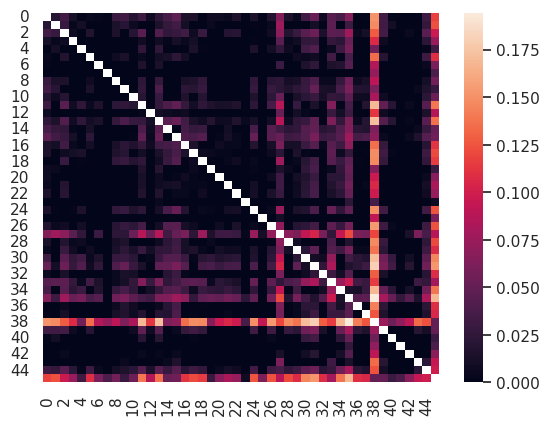

In [50]:
sns.heatmap(fst_results[0].clip(min=0))

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


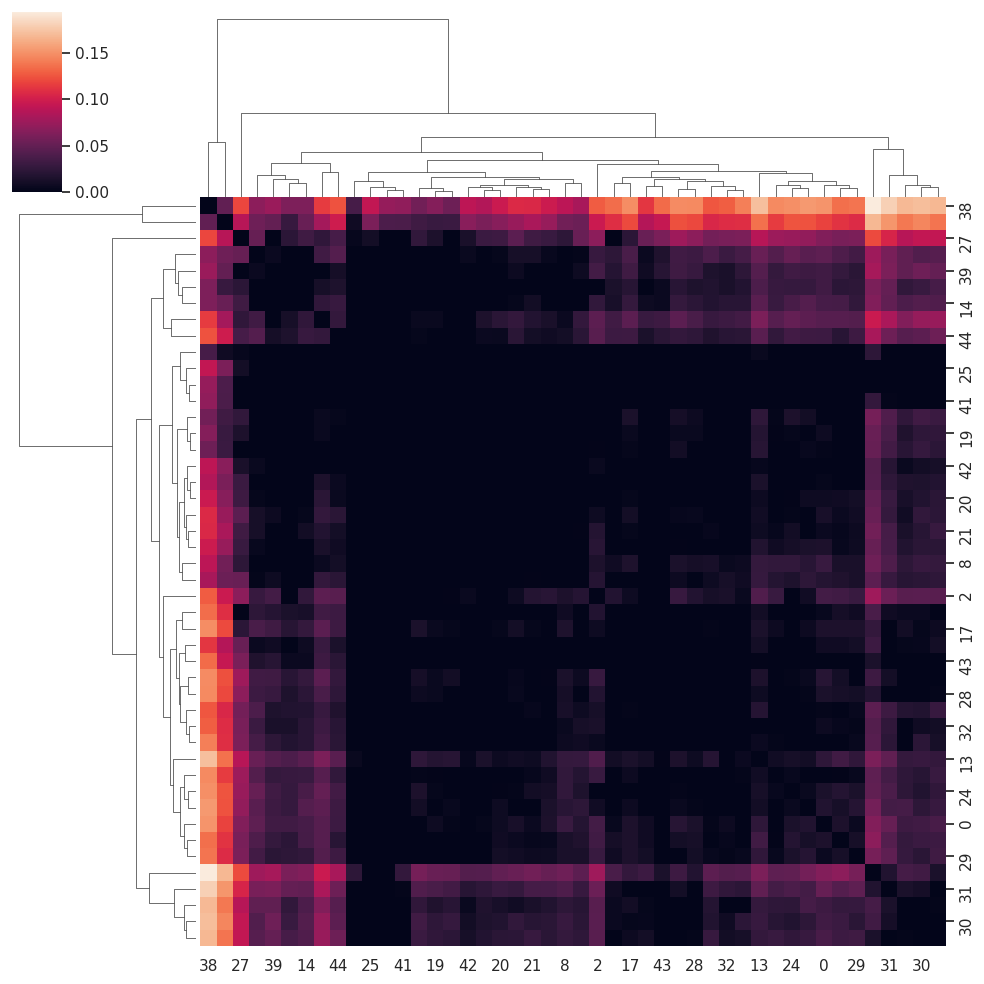

In [51]:
sns.clustermap(np.nan_to_num(fst_results)[0].clip(min=0))

In [52]:
ds["stat_divergence"][0].values

array([[ 9514. ,  9761. ,  9796.5, ...,  9768. , 10379.5, 10229. ],
       [ 9761. ,  9613. ,  9787.5, ...,  9578. , 10385.5, 10346.5],
       [ 9796.5,  9787.5,  9399. , ...,  9715.5, 10472.5,  9929.5],
       ...,
       [ 9768. ,  9578. ,  9715.5, ..., 10036. , 10552. , 10252. ],
       [10379.5, 10385.5, 10472.5, ..., 10552. , 10610. , 10617. ],
       [10229. , 10346.5,  9929.5, ..., 10252. , 10617. ,  8532. ]])

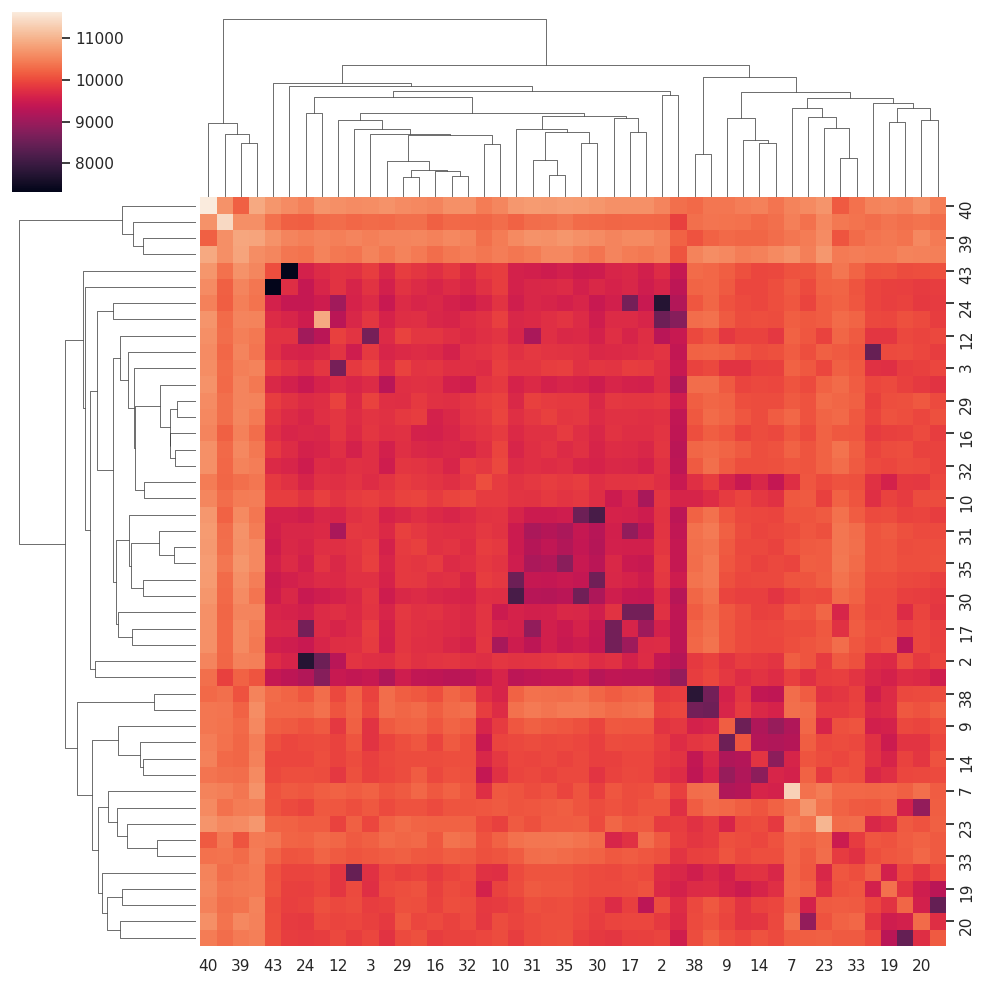

In [53]:
sns.clustermap(ds["stat_divergence"][0].values)

In [54]:
ds

<xarray.Dataset> Size: 40MB
Dimensions:               (windows: 1, cohorts_0: 46, cohorts_1: 46,
                           variants: 35679, cohorts: 46, alleles: 2,
                           samples: 46, ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6)
Dimensions without coordinates: windows, cohorts_0, cohorts_1, variants,
                                cohorts, alleles, samples, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/23)
    stat_Fst              (windows, cohorts_0, cohorts_1) float64 17kB dask.array<chunksize=(1, 46, 46), meta=np.ndarray>
    stat_divergence       (windows, cohorts_0, cohorts_1) float64 17kB dask.array<chunksize=(1, 46, 46), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 26MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    window_start          (windows) int64 8B 0
    window_stop           (windows) int64 8B 35679
    ...                    ...
    variant_id            (variants) object 285kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 36kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 71kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [60]:
# How to handle rewindowing if needed. 
garud_test = sg.window_by_variant(ds.drop_dims(["windows", "cohorts"]), size=25)
garud_test["sample_cohort"] = xr.DataArray([0]*len(garud_test.sample_id), dims="samples")

In [61]:
garud_test

<xarray.Dataset> Size: 13MB
Dimensions:               (windows: 1440, variants: 35679, samples: 46,
                           alleles: 2, ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6)
Dimensions without coordinates: windows, variants, samples, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/21)
    window_contig         (windows) int64 12kB 0 0 0 0 0 0 ... 22 22 22 22 22 23
    window_start          (windows) int64 12kB 0 25 50 75 ... 35630 35655 35666
    window_stop           (windows) int64 12kB 25 50 75 ... 35655 35666 35679
    call_allele_count     (variants, samples, alleles) uint8 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 3MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 285kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 36kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 71kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [62]:
ds_garud = sg.Garud_H(garud_test)
ds_garud

<xarray.Dataset> Size: 13MB
Dimensions:               (windows: 1440, cohorts: 1, variants: 35679,
                           samples: 46, alleles: 2, ploidy: 2, contigs: 26,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Dimensions without coordinates: windows, cohorts, variants, samples, alleles,
                                ploidy, contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/25)
    stat_Garud_h1         (windows, cohorts) float64 12kB dask.array<chunksize=(40, 1), meta=np.ndarray>
    stat_Garud_h12        (windows, cohorts) float64 12kB dask.array<chunksize=(40, 1), meta=np.ndarray>
    stat_Garud_h123       (windows, cohorts) float64 12kB dask.array<chunksize=(40, 1), meta=np.ndarray>
    stat_Garud_h2_h1      (windows, cohorts) float64 12kB dask.array<chunksize=(40, 1), meta=np.ndarray>
    window_contig         (windows) int64 12kB 0 0 0 0 0 0 ... 22 22 22 22 22 23
    window_start          (windows) int64 12kB 0 25 50 75 ... 35630 35655 35666
    ...                    ...
    variant_id            (variants) object 285kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 36kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 71kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 143kB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [63]:
ds_garud.windows.values

array([   0,    1,    2, ..., 1437, 1438, 1439])

<Axes: >

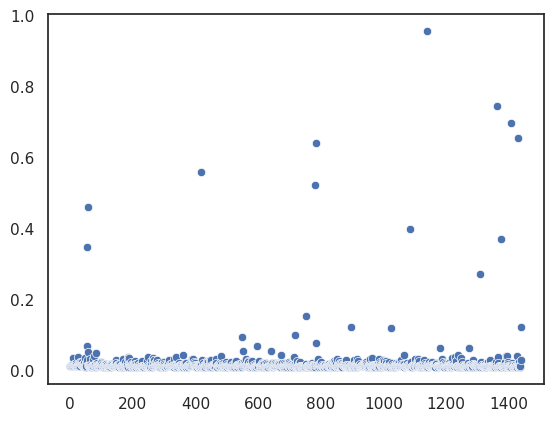

In [64]:
sns.scatterplot(x=ds_garud.windows.values, y=ds_garud.stat_Garud_h12.values.ravel())